# EDA Practice  - Exploring AirBnB Data for Broke Couples
### Background Story and Premise:
Throughout my time studying in Amsterdam, I met and saw a lot of tourists. More than I could bargain for. This was because I lived near a very tourist-dense area where there were loads of international visitors and barely any Dutch people. (If you're asking how I managed to find an apartment to rent in this area, let's just say I got unbelievably lucky)

A category of tourists that I normally bumped into, besides families and drunken British boys in their mid 30's, were young couples. Usually hailing from other European countries, they wanted to temporarily escape their home, flying away to the most romantic honeymoon - and where else to spend this endeavour, if not for the one and only, premium adult playground that is Amsterdam?

There is a problem for these young couples, however. Amsterdam is a relatively expensive city. And when you're young, you're probably not going to be in the right spectrum when it comes to financial wellness - constantly asking about what this costs compared to that (well, unless you have rich parents or bought bitcoin back in 2012) - you're most likely going to be *broke*.

### EDA Aim:

* This EDA will attempt to conduct an exploratory data analysis for this target market. We will try and flesh out the best options for a couple short on cash looking to rent an Airbnb in the city of Amsterdam. 
* Also, at the current time of writing this EDA, my status single.... however, should I in the future get a girlfriend.. I'll probably look on here for references.....
* *Cries in the background*

--------------------------------------------------------------------------------------------------------

Below I implemented an ignore for warnings - this is of course not something i'd recommend but i ran into an issue with updating the data using 'loc' even though my code was basically correct *('settingwithcopy warning')*. I am still in the process of finding out why, but for now, I will install this 

In [1]:
import warnings
warnings.filterwarnings('ignore')

--------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
listings_raw = pd.read_csv("Airbnb-data/listings_details.csv", low_memory= False)

In [4]:
listings_raw.shape

(20030, 96)

Since the dataset has too much columns, let's narrow it down to the most relevant ones

In [6]:
colnames = ["id", "listing_url", "price", "name","neighbourhood","beds",
            "bathrooms", "property_type", "accommodates", 'number_of_reviews',
            'review_scores_rating',"latitude", "longitude"]

listings = listings_raw[colnames]

In [7]:
listings.head() #Let's Peep the Dataset

,id,listing_url,price,name,neighbourhood,beds,bathrooms,property_type,accommodates,number_of_reviews,review_scores_rating,latitude,longitude
0,2818,https://www.airbnb.com/rooms/2818,$59.00,Quiet Garden View Room & Super Fast WiFi,Indische Buurt,2.0,1.5,Apartment,2,248,97.0,52.365755,4.941419
1,3209,https://www.airbnb.com/rooms/3209,$160.00,"Quiet apt near center, great view",Spaarndammer en Zeeheldenbuurt,2.0,1.0,Apartment,5,42,96.0,52.390225,4.873924
2,20168,https://www.airbnb.com/rooms/20168,$80.00,100%Centre-Studio 1 Private Floor/Bathroom,Grachtengordel,1.0,1.0,Townhouse,2,233,87.0,52.365087,4.893541
3,25428,https://www.airbnb.com/rooms/25428,$125.00,Lovely apt in City Centre (Jordaan),Grachtengordel,1.0,1.0,Apartment,3,1,100.0,52.373114,4.883668
4,27886,https://www.airbnb.com/rooms/27886,$150.00,"Romantic, stylish B&B houseboat in canal district",Westelijke Eilanden,1.0,1.0,Houseboat,2,171,99.0,52.386727,4.892078


----------------------------------------------------------------------------------------------------------------------

## Cleaning and Modifying the Data / Setting Limits

In [8]:
# Check missing values
listings.isnull().sum()

id                         0
listing_url                0
price                      0
name                      38
neighbourhood           1653
beds                       7
bathrooms                 10
property_type              0
accommodates               0
number_of_reviews          0
review_scores_rating    2639
latitude                   0
longitude                  0
dtype: int64

In [9]:
#Clean Data with null values = beds, bathrooms 
listings.loc[:, 'beds'] = listings['beds'].dropna()
listings.loc[:, 'bathrooms'] = listings['bathrooms'].dropna()

In [10]:
#0.0 should also be treated as null and therefore should also be dropped
listings.drop(listings[listings['beds'] == 0].index, inplace = True)
listings.drop(listings[listings['bathrooms'] == 0].index, inplace = True)

### Setting a filter which makes sure the listing is indeed for a couple
The 'accommodates' column indicates the maximum and minimum amount of guests a listing can hold. In our case, let's set it exactly to two.

In [11]:
coupleMask = listings['accommodates'] == 2
listings = listings[coupleMask]
listingcount = listings['id'].count()
print(f'In total, we have {listingcount} listings that fall within the couple criteria')

In total, we have 10821 listings that fall within the couple criteria


## Cleaning / Modifying the Price Column

In [12]:
# Convert price from object into int
listings.loc[:, "price"] = listings["price"].replace('[\$,]', '', regex=True).astype(float)

In [13]:
# Omit Data that has 0 for price value 
aboveZeroFilter = listings['price'] > 1
listings = listings[aboveZeroFilter]

In [14]:
#Let's convert the price from Dollars to Euros
#Let's also creat another price column - Indonesian Rupiah (personal use!)

from currency_converter import CurrencyConverter
c = CurrencyConverter()

def dollar_to_euro(x):
    return round(c.convert(x, 'USD','EUR'), 1)

def euro_to_idr(x):
    return round(c.convert(x, 'EUR','IDR'))

listings.loc[:, 'price'] = listings.loc[:, 'price'].apply(dollar_to_euro)
listings.loc[:, 'price_idr'] = listings.loc[:, 'price'].apply(euro_to_idr)

### Checking for outliers

<AxesSubplot:xlabel='price'>

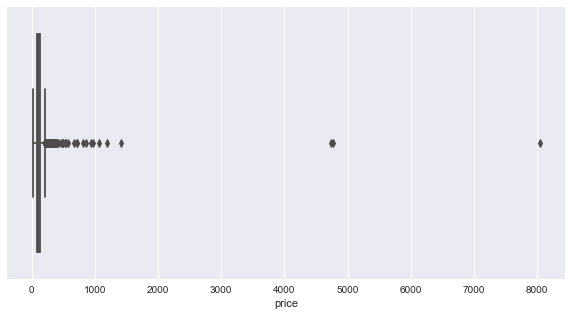

In [15]:
plt.figure(figsize = (10,5))
sns.boxplot(data=listings, x='price')

As we can see, there are a bunch of outliers. It never ceases to amaze me how there is actually a couple of listings above 8000€. 

One may argue that since we are performing analysis only for a target that is 'broke', we can just omit prices that do not fall within a certain range - but hold on - *just what do you mean by 'broke?'* This is of course relative to every person, but to keep it as unambigious as possible, in this analysis I will work with **what's below the 25th Percentile:**

In [16]:
brokelimit = round(listings['price'].quantile(q=0.25))
print(f'We will define the price limit as... {brokelimit}€')
print(f'Split that in two, and you get {brokelimit/2}€ per couple..')

eur_to_idr = c.convert(brokelimit/2, 'EUR','IDR')
print(f'Convert that into IDR, and you get RP {eur_to_idr} per couple..')

We will define the price limit as... 81€
Split that in two, and you get 40.5€ per couple..
Convert that into IDR, and you get RP 617662.26 per couple..


Personally, I think that the prices above are a good enough limit on what constitutes as a 'broke couple' price maximum.

In [17]:
price_mask = listings["price"] <= brokelimit
listings = listings[price_mask]
listingamount = listings['price'].count()
print(f'In total, we have {listingamount} listings that fall within the price range')

In total, we have 2699 listings that fall within the price range


<AxesSubplot:xlabel='price'>

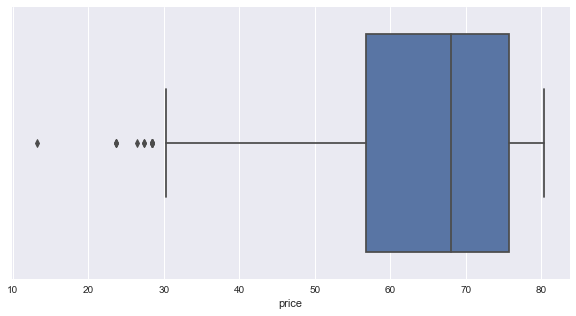

In [18]:
#Let's check the boxplot again - looks great to me!
plt.figure(figsize = (10,5))
sns.boxplot(data=listings, x='price')

**What's the price we can expect on average?**

In [19]:
pricemean = round(listings['price'].mean())
print(f'The average price, when setting the price limit of the data to the 25th Percentile is {pricemean}' + '$')
print(f'Split that in two, and you get {pricemean/2}€ per couple..')

eur_to_idr = c.convert(pricemean/2, 'EUR','IDR')
print(f'Convert that into IDR, and you get RP-{eur_to_idr} per couple..')

The average price, when setting the price limit of the data to the 25th Percentile is 66$
Split that in two, and you get 33.0€ per couple..
Convert that into IDR, and you get RP-503280.36 per couple..


Let's view a histogram to visualize the price distribution:

<AxesSubplot:xlabel='price', ylabel='Count'>

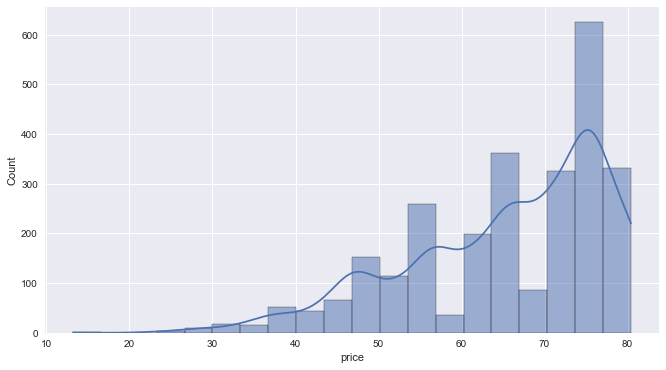

In [27]:
plt.figure(figsize=(11,6))
sns.histplot(data=listings, x='price', kde = True, bins=20)

----------------------------------------------------------------------------------------------------------------------

# Exploratory Data Analysis

### A Closer Investigation of Neighbourhoods
Which Neighbourhood falls into our criteria the most? In other words, which neighbourhood has the most listings when it came to fitting into the criteria of a broke couple?

Text(0.5, 0, 'Neighbourhood Count')

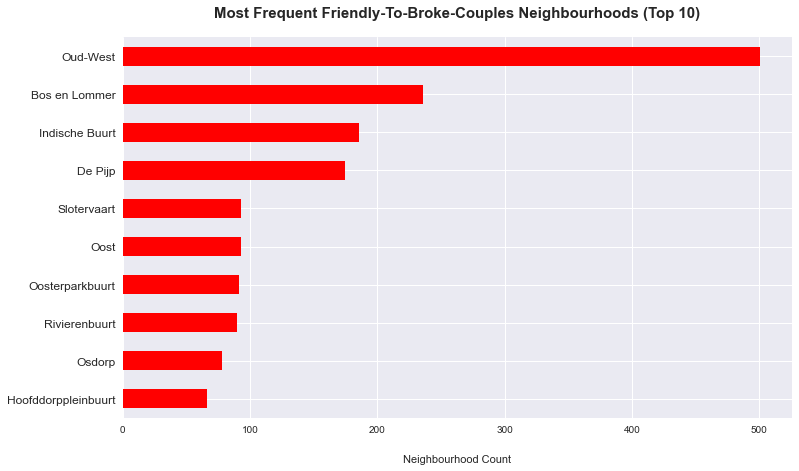

In [21]:
plt.figure(figsize=(12,7))
listings['neighbourhood'].value_counts().head(10).plot(kind='barh', color='red').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.title('Most Frequent Friendly-To-Broke-Couples Neighbourhoods (Top 10)', fontsize= 15, fontweight = 'bold', pad = 20)
plt.xlabel('Neighbourhood Count', labelpad=20)

Looks like the neighbourhood of Oud-West takes the top spot by a big margin - 500 listings in total. This is no surprise because that area is primarily filled with residential apartments to begin with. 

In [48]:
#Checking out the price mean for oud-west
oud_west_mask = listings['neighbourhood'] == 'Oud-West'
oud_west = listings[oud_west_mask]
pricemean = round(oud_west['price'].mean())
print(f"Average price for a listing in Oud-West is {pricemean}€")
print(f'Split that in two, and you get {pricemean/2}€ per couple..')

eur_to_idr = c.convert(pricemean/2, 'EUR','IDR')
print(f'Convert that into IDR, and you get RP {eur_to_idr} per couple..')

Average price for a listing in Oud-West is 68€
Split that in two, and you get 34.0€ per couple..
Convert that into IDR, and you get RP 518531.28 per couple..


------------------------------------------------------------------------------------------------------

# Price Above Everything 
However! If you are a *truly broke* couple, you probably would prioritise price above everything else, correct? Let us then ask, which areas have on average, the *cheapest* AirBnB listings when it comes to accommodating two people:

Text(0.5, 1.0, 'Top 10 Areas with Cheapest Listings (On Average)')

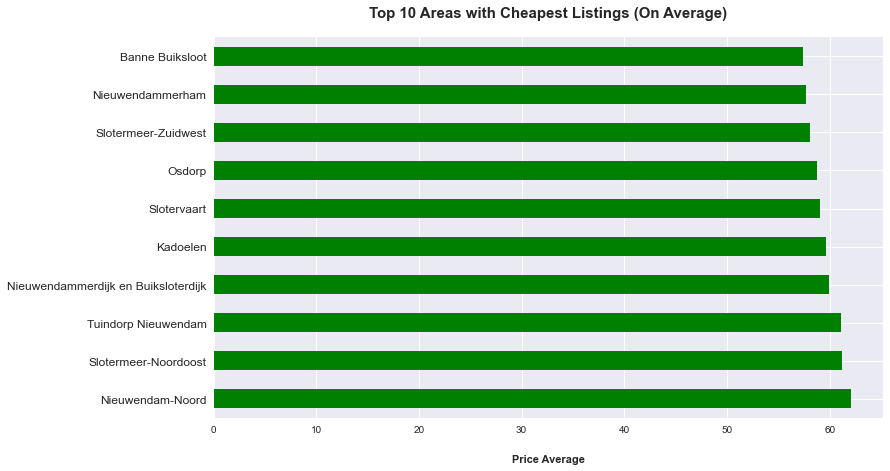

In [38]:
gbo = listings.groupby('neighbourhood')
gboPriceMean = gbo['price'].mean().nsmallest(10)

plt.figure(figsize=(12,7))
gboPriceMean.plot(kind='barh', color='green').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.ylabel(None)
plt.xlabel('Price Average', labelpad=20, fontweight='bold')
plt.title('Top 10 Areas with Cheapest Listings (On Average)', fontsize= 15, fontweight = 'bold', pad = 20)

In [47]:
#Checking out the price mean for Banne Buiksloot
bb_mask = listings['neighbourhood'] == 'Banne Buiksloot'
bb = listings[bb_mask]
pricemean = round(bb['price'].mean())
print(f"Average price for a listing in Banne Buiksloot is {pricemean}€")
print(f'Split that in two, and you get {pricemean/2}€ per couple..')

eur_to_idr = c.convert(pricemean/2, 'EUR','IDR')
print(f'Convert that into IDR, and you get RP {round(eur_to_idr)} per couple..')

Average price for a listing in Banne Buiksloot is 57€
Split that in two, and you get 28.5€ per couple..
Convert that into IDR, and you get RP 434651 per couple..


Unsuprisingly all of the areas are outside the city center - this is no surprise. In exchange for a cheaper listing we are going to have to sacrifice the convenience of being near the large tourist attractions. We should also check the frequency of listings in these neighbourhoods, which is what we'll do below:

Text(0.5, 1.0, 'Frequency of Listings in Cheapest Neighbourhoods')

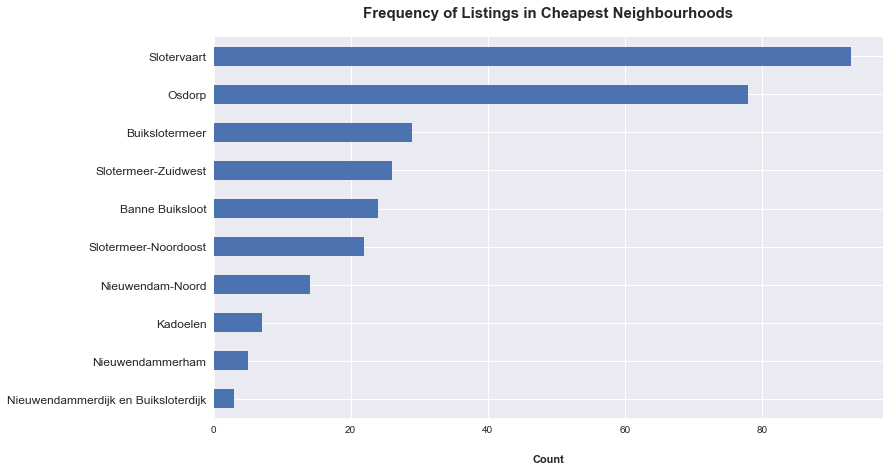

In [42]:
colnames = ['Nieuwendammerham', 'Banne Buiksloot', 'Slotervaart', 'Kadoelen', 'Slotermeer-Zuidwest',
           'Osdorp', 'Nieuwendam-Noord', 'Slotermeer-Noordoost', 'Buikslotermeer',
            'Nieuwendammerdijk en Buiksloterdijk']

cheapest_neighbourhoods = listings[listings['neighbourhood'].isin(colnames)]

plt.figure(figsize=(12,7))
cheapest_neighbourhoods['neighbourhood'].value_counts().plot(kind='barh').invert_yaxis()
plt.yticks(fontsize = 12, rotation = 0)
plt.ylabel(None)
plt.xlabel('Count', labelpad=20, fontweight='bold')
plt.title('Frequency of Listings in Cheapest Neighbourhoods', 
          fontsize= 15, fontweight = 'bold', pad = 20)

### Investigating, and filtering the neighbourhoods above in conjunction with reviews
What about it's score reviews? Does prioritising price mean we have to sacrifice not only the convenience of being outside the city center, but also having to deal with a bad listing in general? 

First of all we need to define what constitutes as a bad listing. We of course cannot tell for sure because we haven't stayed in any of these listings. I think a better way to estimate this is to not use the word 'bad' but 'shady' instead. 

Why is this the case? Because it is a better, more realistic metric for the purposes of this EDA. All of us have a sense of intuitive suspicion when trying to choose a listing. Two measures that are the most popular are:
* When the number of reviews is 0 or below a certain number (i'll go with 10 just to be safe)  
* When the review score rating is low 

Let's first omit listings which has less than 10 reviews

In [84]:
safe_metric_1 = cheapest_neighbourhoods['number_of_reviews'] > 10
cheapest_neighbourhoods = cheapest_neighbourhoods[safe_metric_1]

Next, we'll decide what "low" is in review scores rating

In [73]:
cheapest_neighbourhoods['review_scores_rating'].describe()

count    263.000000
mean      92.365019
std        9.318568
min       20.000000
25%       90.000000
50%       95.000000
75%       98.000000
max      100.000000
Name: review_scores_rating, dtype: float64

<AxesSubplot:xlabel='review_scores_rating'>

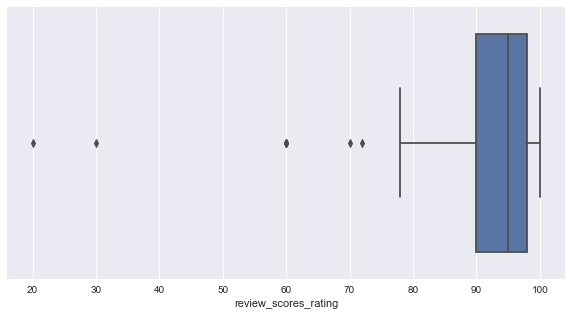

In [75]:
plt.figure(figsize = (10,5))
sns.boxplot(data=cheapest_neighbourhoods, x = 'review_scores_rating')

<AxesSubplot:xlabel='review_scores_rating', ylabel='Density'>

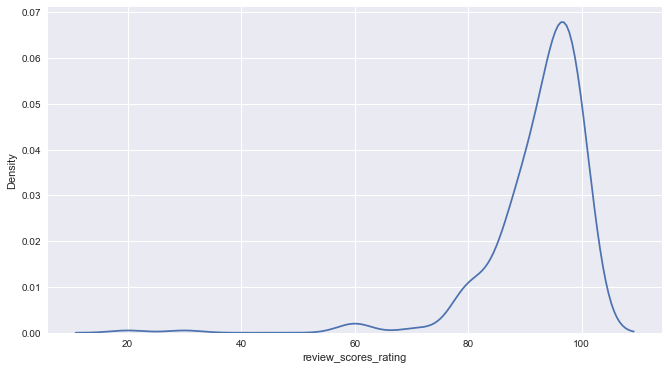

In [72]:
plt.figure(figsize=(11,6))
sns.kdeplot(data=cheapest_neighbourhoods, x='review_scores_rating')

Judging by the description and the two graphs above, it is actually looking quite good because most of the listings that fall within our criteria have pretty good review scores - 92 stars on average. Constituting what a "low star review" proves to be quite difficult. For now, i think a safe bet is to omit the ones below 80, since we have such a high standard to begin with.

In [86]:
safe_metric_2 = cheapest_neighbourhoods['review_scores_rating'] > 80
cheapest_neighbourhoods = cheapest_neighbourhoods[safe_metric_2]

Great! Now we have a (hopefully) safe, reliable list of listings for broke couples who truly prioritise price above everything else. 

In [87]:
cheapest_neighbourhoods.head()

,id,listing_url,price,name,neighbourhood,beds,bathrooms,property_type,accommodates,number_of_reviews,review_scores_rating,latitude,longitude,price_idr
59,97221,https://www.airbnb.com/rooms/97221,37.9,Beautiful and spacious room,Slotervaart,2.0,1.0,Bed and breakfast,2,141,89.0,52.349103,4.836112,578010
258,483779,https://www.airbnb.com/rooms/483779,68.1,Spacious studio apartment in A'dam,Slotervaart,1.0,1.0,Apartment,2,38,98.0,52.349316,4.831327,1038588
283,528594,https://www.airbnb.com/rooms/528594,75.7,Connect-Inn: Clear & Cheerful,Slotervaart,1.0,1.0,Apartment,2,72,96.0,52.358674,4.824760,1154495
332,582280,https://www.airbnb.com/rooms/582280,30.3,"Cats'n'Rooms, Amsterdam West",Slotermeer-Zuidwest,1.0,1.5,Apartment,2,241,87.0,52.376965,4.812768,462103
359,613088,https://www.airbnb.com/rooms/613088,73.8,Your own cottage in the countryside,Buikslotermeer,1.0,1.0,Bed and breakfast,2,310,97.0,52.409915,4.962911,1125518


So - if you are in a broke couple situation and you prioritised price above everything else, the information above will probably suffice as a starting point in your search for a listing. 

Personally I'm quite satisfied with the findings above. I used to live in Osdorp and it's really not a bad area - lots of places you can hang around in. The same goes for slotervaart. If I had a Girlfriend (imaginary one at the moment) and we were on a budget, I wouldn't mind staying in these listings. 

### Listing Randomiser

Let's be honest though. Even though this is a starting point, some of us are going to spend more time pickling with what we have rather than just booking a place immediately. Much like spending a couple of hours deciding what to watch on your favorite streaming service and ending up watching a 20 minute episode of The Office. So i've created a randomiser to pick a listing for people like these!

* Warning: This dataset is outdated. Some of the listings have been taken off AirBnB and are therefore not there anymore. If that is the case, shuffle again

In [146]:
def shuffle():
    randomlisting = cheapest_neighbourhoods.sample()
    return randomlisting['listing_url']

In [153]:
shuffle()

258    https://www.airbnb.com/rooms/483779
Name: listing_url, dtype: object